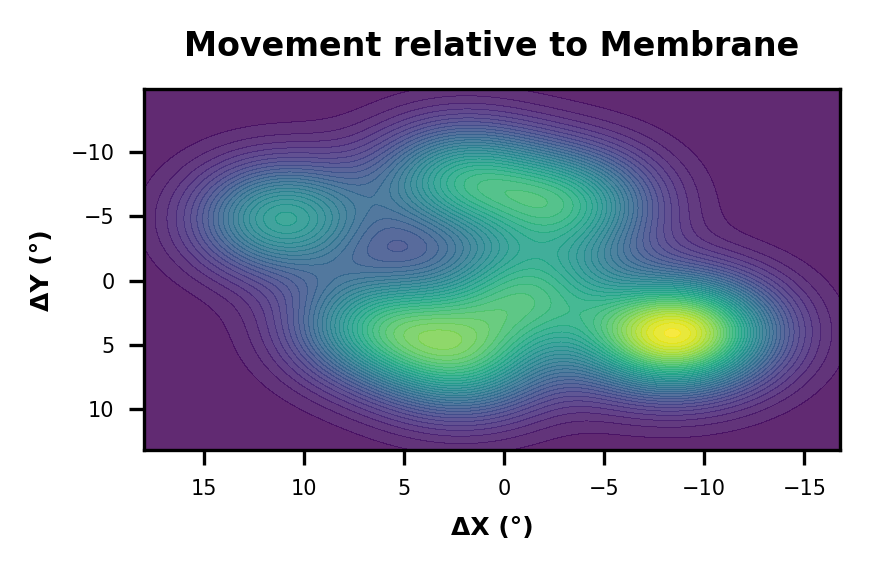

In [ ]:
import os, glob
import numpy as np
import mrcfile
import matplotlib.pyplot as plt

# === Parameters ===
HIGH_PCT = 98        # Percentile threshold for membrane detection
R_INNER = 0.25       # Inner radius of annular search region (fraction of max)
R_OUTER = 0.85       # Outer radius of annular search region
Z_HALF_RANGE = 30    # Z-slices to sample around membrane center

def class_key(path):
    """Extract class number from filename for sorting."""
    return int(os.path.splitext(os.path.basename(path))[0].split("class")[-1])

def annulus_mask_2d(shape, center):
    """Create annular mask between R_INNER and R_OUTER."""
    h, w = shape
    cy, cx = center
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")
    R = np.sqrt((Y - cy)**2 + (X - cx)**2)
    r_max = R.max()
    return (R > R_INNER * r_max) & (R < R_OUTER * r_max)

def pca_line_2d(coords):
    """Fit principal axis through 2D coordinates."""
    m = coords.mean(axis=0)
    cov = (coords - m).T @ (coords - m)
    eigvals, eigvecs = np.linalg.eigh(cov)
    d = eigvecs[:, np.argmax(eigvals)]
    return m, d / np.linalg.norm(d)

def fit_membrane_stack(vol):
    """Extract 3D membrane normal from volume stack."""
    # Find membrane center slice by maximum mean intensity
    z_mem = int(vol.mean(axis=(1, 2)).argmax())
    img = vol[z_mem].astype(np.float32)
    h, w = img.shape
    
    # Detect membrane in central slice
    ann = annulus_mask_2d(img.shape, (h / 2, w / 2))
    thr = np.percentile(img[ann], HIGH_PCT)
    mem_mask = (img >= thr) & ann
    coords = np.column_stack(np.nonzero(mem_mask))
    
    # Get in-plane normal via PCA
    _, d = pca_line_2d(coords)
    n2 = np.array([-d[1], d[0]], float)  # Perpendicular to principal axis
    n2 /= np.linalg.norm(n2)
    
    # Track membrane tilt across Z-slices
    zdim = vol.shape[0]
    z_low = max(0, z_mem - Z_HALF_RANGE)
    z_high = min(zdim - 1, z_mem + Z_HALF_RANGE)
    z_vals, c_vals = [], []
    
    for z in range(z_low, z_high + 1):
        img = vol[z].astype(np.float32)
        thr = np.percentile(img[ann], HIGH_PCT)
        mem_mask = (img >= thr) & ann
        coords = np.column_stack(np.nonzero(mem_mask))
        if coords.shape[0] < 30:
            continue
        proj = coords @ n2
        c_vals.append(proj.mean())
        z_vals.append(z)
    
    # Linear fit gives Z-component of tilt
    a = np.polyfit(z_vals, c_vals, 1)[0] if len(z_vals) >= 2 else 0.0
    
    # Construct 3D normal (Z, Y, X order)
    N_zyx = np.array([-a, n2[0], n2[1]], float)
    N_zyx /= np.linalg.norm(N_zyx)
    if N_zyx[0] < 0:
        N_zyx = -N_zyx
    
    return np.array([N_zyx[2], N_zyx[1], N_zyx[0]], float)  # Return as (X, Y, Z)

def project_normals(normals):
    """Project 3D normals onto tangent plane of mean normal."""
    normals = np.asarray(normals, float)
    n0 = normals.mean(axis=0)
    n0 /= np.linalg.norm(n0)
    
    # Build orthonormal basis in tangent plane
    tmp = np.array([1.0, 0.0, 0.0]) if abs(np.dot(n0, [1, 0, 0])) < 0.9 else np.array([0.0, 1.0, 0.0])
    t1 = tmp - np.dot(tmp, n0) * n0
    t1 /= np.linalg.norm(t1)
    t2 = np.cross(n0, t1)
    
    # Project each normal onto tangent plane
    coords = []
    for n in normals:
        cos_th = np.clip(np.dot(n0, n), -1.0, 1.0)
        th = np.arccos(cos_th)
        
        if th < 1e-8:
            u = t1
        else:
            u = (n - cos_th * n0) / np.sin(th)
            u /= np.linalg.norm(u)
        
        th_deg = np.degrees(th)
        coords.append((th_deg * np.dot(u, t1), th_deg * np.dot(u, t2)))
    
    return np.array(coords)

# === Main Analysis ===
base_dir = "path/to/membrane_classes/"
mrc_paths = sorted(
    [p for p in glob.glob(os.path.join(base_dir, "Membrane_class*.mrc")) if "_not" not in os.path.basename(p)],
    key=class_key,
)

# Extract membrane normals from each class
normals = []
for path in mrc_paths:
    with mrcfile.open(path, permissive=True) as mrc:
        vol = mrc.data.astype(np.float32)
    normals.append(fit_membrane_stack(vol))

# Project normals onto 2D tangent plane
coords = project_normals(normals)

# === Visualization ===
# Gaussian kernel density plot
sigma = 3
margin = 7
x_min, x_max = coords[:, 0].min() - margin, coords[:, 0].max() + margin
y_min, y_max = coords[:, 1].min() - margin, coords[:, 1].max() + margin

X, Y = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 200))
Z = sum(np.exp(-((X - px)**2 + (Y - py)**2) / (2 * sigma**2)) for px, py in coords)

fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
ax.contourf(X, Y, Z, levels=40, alpha=0.85, cmap="viridis")
ax.set_xlabel("ΔX (°)", fontweight="bold", fontsize=6)
ax.set_ylabel("ΔY (°)", fontweight="bold", fontsize=6)
ax.set_title("Movement relative to Membrane", fontweight="bold", fontsize=8, pad=8)
ax.tick_params(labelsize=5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect("auto")
plt.tight_layout()
plt.show()